In [1]:
# Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None


In [2]:
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)

from tqdm import tqdm


# Generalities

The structure of the Vindr dataset is quite straight forward:
1. From the general directory, there are subdirectories, one for each patient.
2. Inside of each subdirectory you can find the images.

In [3]:
# read metadata file
vindr_original_directory = Path('/home/habtamu/physionet.org/files/vindr-mammo/1.0.0')
metadata_path = vindr_original_directory / 'metadata.csv'
# read csv file
metadata = pd.read_csv(metadata_path)
# len
print(f'Number of rows: {len(metadata)}')
# columns
print(f'Columns: {metadata.columns}')
# SOP Instance UID values are unique (no duplicates in images)
print(f'Number of unique SOP Instance UID values (images id): {len(metadata["SOP Instance UID"].unique())}')
# Series Instance UID values are not unique (duplicates in series)
print(f'Number of unique Series Instance UID values (patients id): {len(metadata["Series Instance UID"].unique())}')

Number of rows: 20000
Columns: Index(['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1',
       'Patient's Age', 'View Position', 'Image Laterality',
       'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing',
       'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit',
       'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope',
       'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name'],
      dtype='object')
Number of unique SOP Instance UID values (images id): 20000
Number of unique Series Instance UID values (patients id): 5036


# Read images and save as png

In [4]:
# go through all files in the dicom files in the subdirevtories of all levels in the images directory
images_directory = vindr_original_directory / 'images'
# get all subdirectories
subdirectories = [x for x in images_directory.iterdir() if x.is_dir()]
# get all files in the subdirectories hat are dicom files
files = []
for subdirectory in subdirectories:
    files += [x for x in subdirectory.iterdir() if x.is_file() and x.suffix == '.dicom']
# print the number of files
print(f'Number of files: {len(files)}')

Number of files: 20000


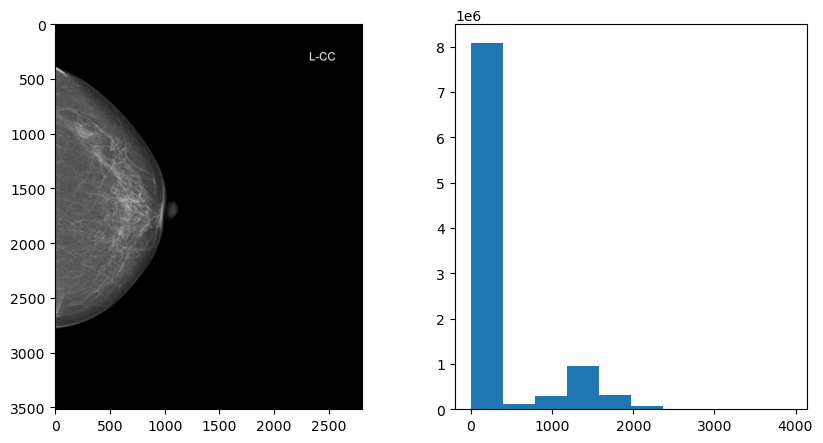

Image shape: (3518, 2800)
Image type: uint16


In [48]:
# read a dicom file
path = files[10]
ds = pydicom.dcmread(path)
# apply the voi lut and convert to uint16
image_array = apply_voi_lut(ds.pixel_array, ds)
# image_array = ds.pixel_array

if image_array.dtype != 'uint16':
    print(f'Image array type: {image_array.dtype}')
if ds.ImageLaterality == 'R':
    image_array = np.fliplr(image_array)

# show the image and histogram
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_array, cmap='gray')
ax[1].hist(image_array.ravel())
plt.show()

print(f'Image shape: {image_array.shape}')
print(f'Image type: {image_array.dtype}')


# Rescale

Reshape max value: 3451


array([347])

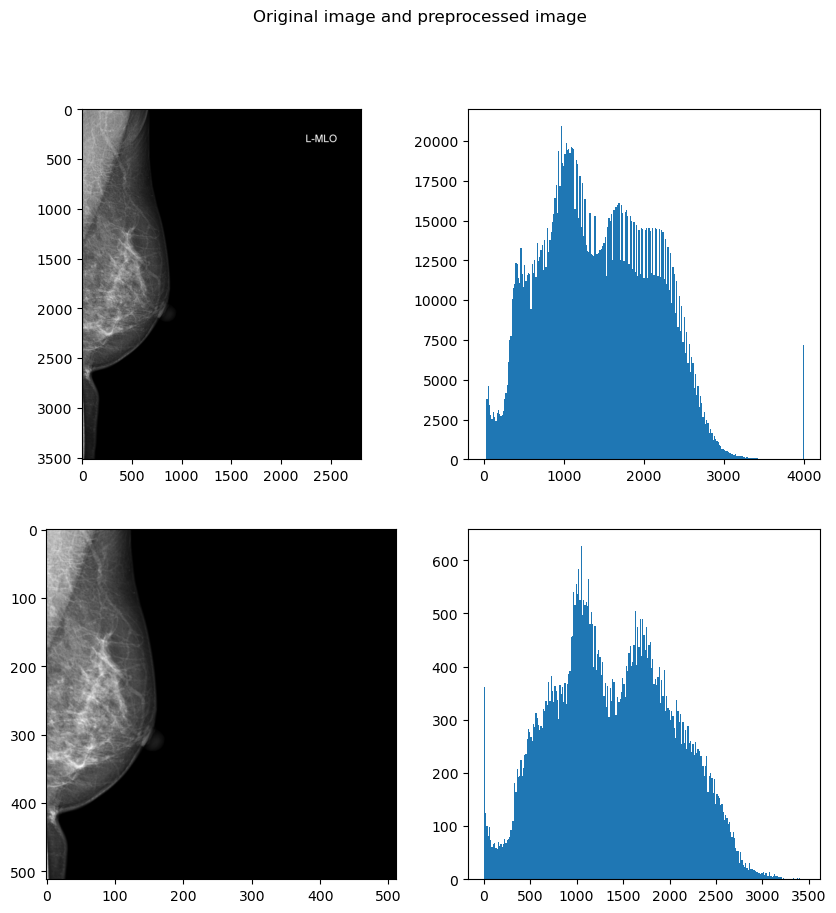

In [17]:
# get all images in folder
images_directory = repo_path / 'data/vindr-mammo/images/siemens15k'
images = [x for x in images_directory.iterdir() if x.is_file() and x.suffix == '.png']
# HP
resolution = 512

#example image
image_path = images[0]
preprocess = Compose(
        [ # classic squared aspect-preserved centered image
            Resize(resolution, interpolation= InterpolationMode.BILINEAR),
            CenterCrop(resolution), 
        ]
    )

im = Image.open(image_path)
im_preprocessed = preprocess(im)

# make array of both images
im_array = np.asarray(im)
im_preprocessed_array = np.asarray(im_preprocessed)


# show both images and histograms, dont show zero values in histogram
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(im_array, cmap='gray')
ax[0,1].hist(im_array.ravel(), bins=255, range=(1,im_array.max()))
ax[1,0].imshow(im_preprocessed_array, cmap='gray')
ax[1,1].hist(im_preprocessed_array.ravel(), bins=255, range=(1,im_preprocessed_array.max()))
fig.suptitle('Original image and preprocessed image')
print(f'Reshape max value: {im_preprocessed_array.max()}')

# max value position
position = np.where(im_preprocessed_array == im_preprocessed_array.max())
position[0]

# Normalize using relative maximum

The max value accepted could be the max aming all image.<br>
Nevertheless this approach could bring some unwanted artefacts and reduce the actual information range.
For this, we decided to visualize the image histogram and set a threshold on 3500, eventhough the max value goes up to 4000 in some cases (artifacts).

Text(0.5, 0.98, 'Scaled image and uint8 image')

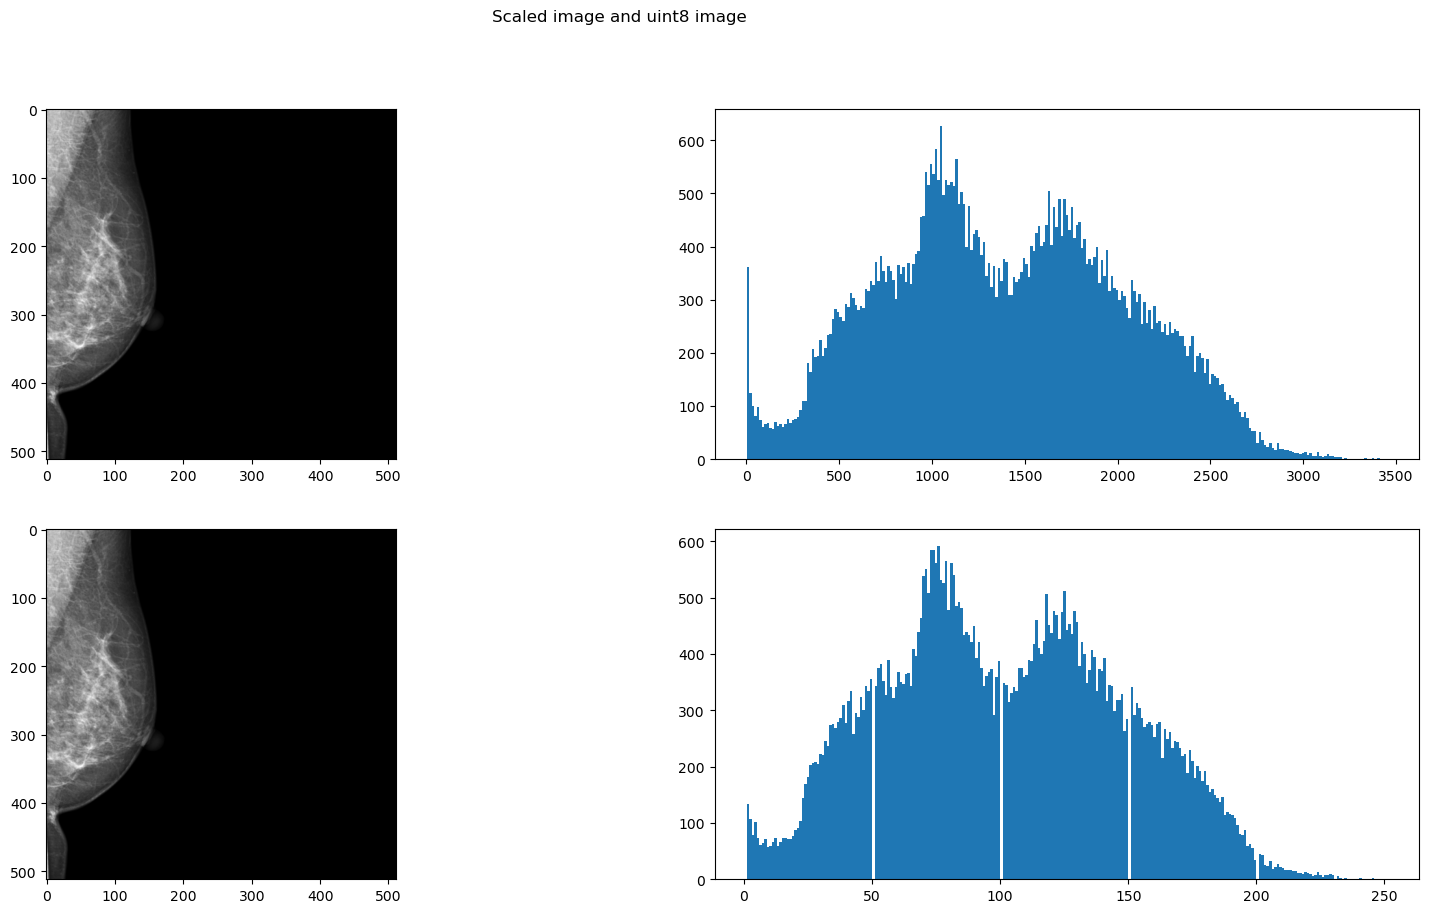

In [18]:
# scale to 0-255 and convert to uint8
im_scaled = (im_preprocessed_array / 3500.0)*255.0
# saturate the values above 255
im_scaled[im_scaled > 255] = 255
im_uint8 = im_scaled.astype(np.uint8)

fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].imshow(im_preprocessed_array, cmap='gray')
ax[0,1].hist(im_preprocessed_array.ravel(), bins=255, range=(1,im_preprocessed_array.max()))
ax[1,0].imshow(im_uint8, cmap='gray')
ax[1,1].hist(im_uint8.ravel(), bins=255, range=(1,im_uint8.max()))
fig.suptitle('Scaled image and uint8 image')
# convert to RGB
# im_RGB = np.stack((im_uint8,)*3, axis=-1)